Cargar las bibliotecas necesarias

In [ ]:
from skimage.io import imread_collection
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler
from skimage.measure import label, regionprops
import pandas as pd

Visualizacion de la imagen binarizada

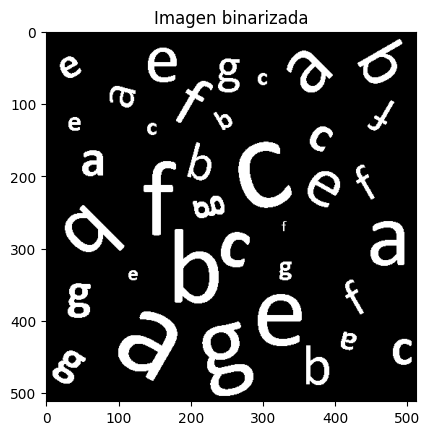

In [ ]:
im = cv2.imread('sopa_letras.png')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Binarizar la imagen
rt, bw = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV)

# Etiquetar
etiquetas = label(bw)
props = regionprops(etiquetas)

plt.imshow(bw, cmap="gray")
plt.title("Imagen binarizada")
plt.show()

## Extracción de características de la imagen

In [ ]:
data = []

for region in props:
    if region.area < 50:  # filtrar ruido
        continue

    # (1) Momentos de Hu (primeros 4)
    momentos = cv2.moments(region.image.astype(np.uint8))
    huMoments = cv2.HuMoments(momentos).flatten()[:4]

    # (2) Perímetro
    contours, _ = cv2.findContours(region.image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimetro = cv2.arcLength(contours[0], True) if contours else 0

    # (3) Redondez
    redondez = (4 * np.pi * region.area) / (perimetro ** 2) if perimetro > 0 else 0

    # (4) Ángulo de orientación (si es posible ajustar elipse)
    angulo = None
    if len(region.coords) >= 5:
        coords = np.array(region.coords)
        ellipse = cv2.fitEllipse(coords[:, ::-1])  # coords en formato (x,y)
        angulo = ellipse[2]

    # Guardar en la lista
    data.append({
        "Hu1": huMoments[0],
        "Hu2": huMoments[1],
        "Hu3": huMoments[2],
        "Hu4": huMoments[3],
        "Perimetro": perimetro,
        "Redondez": redondez,
        "Angulo": angulo
    })

Crear DataFrame con Pandas

In [ ]:
df = pd.DataFrame(data)

print("=== Descriptores extraídos ===")
print()
print(df)

=== Descriptores extraídos ===

         Hu1       Hu2       Hu3       Hu4   Perimetro  Redondez      Angulo
0   0.425378  0.025908  0.013871  0.000732  226.350286  0.297270   51.157650
1   0.337127  0.003917  0.000911  0.000407  206.710677  0.285858  174.724167
2   0.363250  0.011855  0.002181  0.000449  251.705625  0.260627  131.575577
3   0.257982  0.001658  0.000276  0.000161  129.195958  0.351584  143.139633
4   0.364220  0.032158  0.001117  0.000161  188.710677  0.261831    3.653999
5   0.292098  0.010319  0.002518  0.000852   67.112698  0.365487    0.000000
6   0.533992  0.213339  0.025221  0.008095  215.178713  0.203008   40.133858
7   0.354090  0.010660  0.002156  0.000553  150.325901  0.270814  102.380318
8   0.535181  0.213728  0.025933  0.008523  153.580734  0.204049   40.317059
9   0.292864  0.012324  0.004910  0.000336   88.911687  0.449861  138.323303
10  0.230027  0.000899  0.000148  0.000066   81.455844  0.409090  173.369629
11  0.292098  0.010319  0.002518  0.000852  

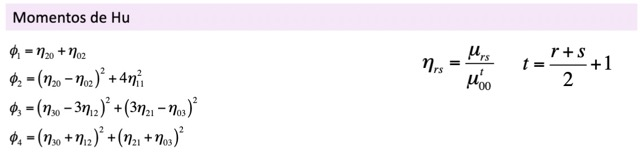

Visualizar centroides en cada letra de la imagen

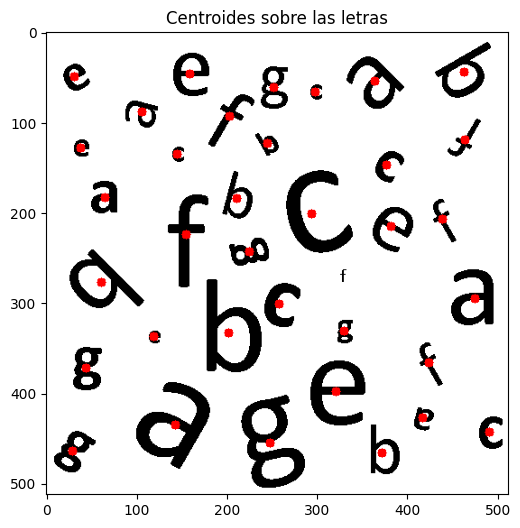

In [ ]:
if len(im.shape) == 2:
    img_color = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
else:
    img_color = im.copy()

# Dibujar centroide en cada letra
for region in props:
    if region.area < 50:
        continue
    y, x = region.centroid
    cv2.circle(img_color, (int(x), int(y)), 5, (0, 0, 255), -1)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Centroides sobre las letras")
plt.show()